# Load data

In [112]:
# Import packages you need
import pandas as pd
import numpy as np
import datetime
from datetime import date


# Packages for dashboard
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.express as px

import pandas as pd
from sklearn.linear_model import LinearRegression


import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score

In [2]:
# If you can't view charts in Jupyter Lab
import plotly.io as pio
pio.renderers.default = 'iframe' 

In [3]:
assets = pd.read_csv('Assets.csv')
events = pd.read_csv('events.csv')
collections = pd.read_csv('Collections.csv')

C:\Users\15706\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning:

Columns (13,14) have mixed types.Specify dtype option on import or set low_memory=False.



In [4]:
assets_sim = assets[['token_id', 'owner_address',
       'collection_slug', 'last_sale_total_price', 'name', 'num_sales', 'asset_contract_owner',
       'asset_favorites', 'asset_category']]

In [5]:
collections_sim = collections[['slug', 'primary_asset_contracts_address',
       'display_data_card_display_style',
       'safelist_request_status', 'name', 'telegram_url', 'twitter_username',
       'instagram_username', 'discord_url', 'medium_username', 'external_url']]

In [6]:
events_sim = events[['asset_token_id','collection_slug', 'created_date', 'id', 'quantity',
       'listing_time', 'event_type', 'total_price', 'auction_type', 'duration']]

## Pie chart

In [7]:
# Get most popular categories
asset_categories = assets_sim.groupby('asset_category')['token_id'].count().sort_values(ascending=False)
asset_categories

asset_category
collectibles          5283
art                   3541
utility               2280
sports                1425
domain-names          1211
trading-cards          806
virtual-worlds         706
music                  549
photography            483
science&technology     265
Name: token_id, dtype: int64

In [8]:
pie_chart = px.pie(
                values= asset_categories.values,
                title='Major Categories', 
                names= asset_categories.index,
                hole=.3,
                color_discrete_sequence=px.colors.qualitative.G10,
                width=500, height =500
                )
pie_chart.update(layout=dict(title=dict(x=0.5)))
pie_chart.show()

## Bar chart

In [9]:
# Get % of assets having social media account links
social_media_linkage = collections_sim[['telegram_url', 'twitter_username', 'instagram_username',
       'discord_url', 'medium_username']].sum()/len(collections_sim)*100
social_media_linkage = social_media_linkage.sort_values(ascending=False)

In [10]:
df_social_media_linkage = pd.DataFrame({'linkage': social_media_linkage.values, 'media_link':social_media_linkage.index})
df_social_media_linkage['media']=df_social_media_linkage['media_link'].apply(lambda x: x.split('_')[0])
df_social_media_linkage

,linkage,media_link,media
0,69.166083,discord_url,discord
1,48.913805,instagram_username,instagram
2,47.161878,twitter_username,twitter
3,15.346882,medium_username,medium
4,7.077786,telegram_url,telegram


In [11]:
bar_chart = px.bar(df_social_media_linkage, x='media', y='linkage',title="Social Media Linkage %",
                  width=500, height =500)
bar_chart.update(layout=dict(title=dict(x=0.5)))
bar_chart.update_layout(
    xaxis_title="Social Medias",
    yaxis_title="Linkage %")
bar_chart.show()

## Boxplot

In [12]:
# Notice the values in asset_favorites are not cleaned, there are values like "1.1K" inside
assets_sim['num_check'] = assets_sim['asset_favorites'].str.find('K')
assets_sim['favorite'] = assets_sim['asset_favorites'].apply(lambda x: float(x.split('K')[0])*1000 if len(x.split('K'))>1 else np.nan)
assets_sim['favorite'].fillna(assets_sim['asset_favorites'],inplace=True)
assets_sim['favorite'] = assets_sim['favorite'].apply(lambda x: int(x))

<ipython-input-12-cf77a8ac5067>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-12-cf77a8ac5067>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\15706\anaconda3\lib\site-packages\pandas\core\generic.py:6392: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-12-cf77a8ac5067>:5: SettingWit

In [13]:
# Remove outlier after inpsection
assets_sim_clean = assets_sim.drop(assets_sim[assets_sim['favorite']==321200].index)

# Merge table to generate insights

In [50]:
tb_1 = events_sim.merge(collections_sim, left_on='collection_slug', right_on = 'slug')
tb_1.pop('slug')
tb_1.pop('name')
all_nfts = tb_1.merge(assets_sim, left_on=['collection_slug', 'asset_token_id'], right_on =['collection_slug', 'token_id'], how='left')

In [51]:
from datetime import date
all_nfts['date'] = all_nfts['created_date'].apply(lambda x: x.split('T')[0])
all_nfts['date'] = all_nfts['date'].apply(lambda x: date(*map(int, x.split('-'))))

In [52]:
# Choose data from successful transactions, top 4 categories and in year 2022
sales_info = all_nfts[all_nfts['event_type']=='successful']
sales_info['major_categories'] = sales_info['asset_category'].apply(lambda x: x in asset_categories[:4].index)
sales_info = sales_info[sales_info['major_categories']==1]
sales_info = sales_info[sales_info['date'] > datetime.date(2022,1,1)]

<ipython-input-52-7c222fd664d9>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [53]:
sales_agg = sales_info.groupby(['date','asset_category']).count().reset_index(level='asset_category').reset_index()
sales_agg

,date,asset_category,asset_token_id,collection_slug,created_date,id,quantity,listing_time,event_type,total_price,...,token_id,owner_address,last_sale_total_price,name,num_sales,asset_contract_owner,asset_favorites,num_check,favorite,major_categories
0,2022-01-02,art,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6
1,2022-01-02,collectibles,9,9,9,9,9,9,9,9,...,9,9,9,7,9,9,9,9,9,9
2,2022-01-02,sports,2,2,2,2,2,2,2,2,...,2,2,2,2,2,1,2,2,2,2
3,2022-01-02,utility,34,34,34,34,34,34,34,34,...,34,34,34,34,34,34,34,34,34,34
4,2022-01-03,art,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,2022-03-05,utility,433,433,433,433,433,406,433,433,...,433,433,395,427,433,401,433,433,433,433
244,2022-03-06,art,24,24,24,24,24,19,24,24,...,24,24,23,23,24,21,24,24,24,24
245,2022-03-06,collectibles,27,27,27,27,27,22,27,27,...,27,27,21,27,27,21,27,27,27,27
246,2022-03-06,sports,12,12,12,12,12,12,12,12,...,12,12,12,12,12,11,12,12,12,12


In [54]:
line_chart_sales = px.line(sales_agg, x='date', y='num_sales',
                 color='asset_category', title='# Sales',
                 width=500, height =500, color_discrete_sequence=px.colors.qualitative.G10)
line_chart_sales.update(layout=dict(title=dict(x=0.5)))
line_chart_sales.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
))

line_chart_sales.show()

In [55]:
line_chart_favorite = px.line(sales_agg, x='date', y='favorite',
                 color='asset_category', title='# favorite',
                 width=500, height =500, color_discrete_sequence=px.colors.qualitative.G10)
line_chart_favorite.update(layout=dict(title=dict(x=0.5)))
line_chart_favorite.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
))

line_chart_favorite.show()

In [56]:
# Clean prices format
all_nfts.last_sale_total_price = all_nfts.last_sale_total_price.apply(lambda x: float(x))
all_nfts.total_price = all_nfts.total_price.apply(lambda x: float(x))

# Drop one outlier
all_nfts.drop(34621,inplace=True)

In [57]:
scatter_plot = px.scatter(all_nfts, x='last_sale_total_price', y="total_price",  title="Price changes", 
                          range_y = [1, 25], trendline="ols", width=500, height =500)
scatter_plot.update_xaxes(title_text="Last price in log", type="log")
scatter_plot.update_yaxes(title_text="Current price in log", type="log")
scatter_plot.update(layout=dict(title=dict(x=0.5)))

scatter_plot.show()

In [58]:
# Select data from auction creation and in year 2022
auction_info = all_nfts[all_nfts['event_type']=='created']
auction_info['duration_days'] = auction_info['duration']/86400

auction_agg = auction_info.groupby(['date'])['duration_days'].mean().reset_index()
auction_agg = auction_agg[auction_agg['date']>datetime.date(2022,1,1)]

<ipython-input-58-884b776fe00c>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [59]:
line_chart_auction = px.line(auction_agg, x='date', y='duration_days', title='Average auction duration',
                width=500, height =500, color_discrete_sequence=px.colors.qualitative.G10)
line_chart_auction.update(layout=dict(title=dict(x=0.5)))
line_chart_auction.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
))

line_chart_auction.show()

In [60]:
# See the distribution of event type
event_type = all_nfts.groupby('event_type')['token_id'].count().sort_values(ascending=False)
event_type

event_type
created          41593
successful       18960
offer_entered    17425
transfer          8351
cancelled          445
bid_entered        156
bid_withdrawn      124
approve              1
Name: token_id, dtype: int64

In [61]:
# Choose data from successful transactions, top 4 auction_type and in year 2022
event = all_nfts
#auction['major_auction_type'] = auction['auction_type'].apply(lambda x: x in auction_type[:4].index)
#auction = auction[auction['major_auction_type']==1]
event = event[event['date'] > datetime.date(2022,1,1)]

In [62]:
event_agg = event.groupby(['date','event_type']).count().reset_index(level='event_type').reset_index()
event_agg

,date,event_type,asset_token_id,collection_slug,created_date,id,quantity,listing_time,total_price,auction_type,...,token_id,owner_address,last_sale_total_price,name,num_sales,asset_contract_owner,asset_favorites,asset_category,num_check,favorite
0,2022-01-02,created,17,17,17,17,17,17,0,17,...,17,17,11,14,17,16,17,17,17,17
1,2022-01-02,offer_entered,5,5,5,5,5,0,0,0,...,5,5,4,5,5,4,5,5,5,5
2,2022-01-02,successful,67,67,67,67,67,66,67,0,...,67,67,67,65,67,55,67,67,67,67
3,2022-01-02,transfer,9,9,9,9,9,0,0,0,...,9,9,5,9,9,9,9,9,9,9
4,2022-01-03,cancelled,3,3,3,3,3,3,3,0,...,3,3,3,3,3,3,3,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333,2022-03-06,cancelled,22,22,22,22,22,22,22,0,...,22,22,20,22,22,20,22,22,22,22
334,2022-03-06,created,1476,1476,1476,1476,1476,1475,0,1476,...,1474,1474,768,1464,1474,1404,1474,1474,1474,1474
335,2022-03-06,offer_entered,3485,3485,3485,3485,3485,0,0,0,...,3482,3482,2981,3367,3482,3148,3482,3482,3482,3482
336,2022-03-06,successful,344,344,344,344,344,321,344,1,...,343,343,332,341,343,324,343,343,343,343


In [63]:
# sales by aution type 
pie_chart = px.pie(
                values= event_type.values,
                title='Transaction Successful rate', 
                names= event_type.index,
                hole=.3,
                color_discrete_sequence=px.colors.qualitative.G10,
                width=500, height =500
                )
pie_chart.update(layout=dict(title=dict(x=0.5)))
pie_chart.show()

# Machine Learning

In [64]:
all_nfts.columns

Index(['asset_token_id', 'collection_slug', 'created_date', 'id', 'quantity',
       'listing_time', 'event_type', 'total_price', 'auction_type', 'duration',
       'primary_asset_contracts_address', 'display_data_card_display_style',
       'safelist_request_status', 'telegram_url', 'twitter_username',
       'instagram_username', 'discord_url', 'medium_username', 'external_url',
       'token_id', 'owner_address', 'last_sale_total_price', 'name',
       'num_sales', 'asset_contract_owner', 'asset_favorites',
       'asset_category', 'num_check', 'favorite', 'date'],
      dtype='object')

In [65]:
scatter_plot = px.scatter(all_nfts, x='last_sale_total_price', y="total_price",  title="Price changes", 
                          range_y = [1, 25], trendline="ols", width=500, height =500)
scatter_plot.update_xaxes(title_text="Last price in log", type="log")
scatter_plot.update_yaxes(title_text="Current price in log", type="log")
scatter_plot.update(layout=dict(title=dict(x=0.5)))

scatter_plot.show()

In [66]:
scatter_plot = px.scatter(all_nfts, x='quantity', y="total_price",  title="quantity vs total_price", 
                          range_y = [1, 25], trendline="ols", width=500, height =500)
scatter_plot.update_xaxes(title_text="quantity in log", type="log")
scatter_plot.update_yaxes(title_text="Current price in log", type="log")
scatter_plot.update(layout=dict(title=dict(x=0.5)))

scatter_plot.show()

In [67]:
scatter_plot = px.scatter(all_nfts, x='favorite', y="total_price",  title="favorite vs total_price", 
                          range_y = [1, 25], trendline="ols", width=500, height =500)
scatter_plot.update_xaxes(title_text="favorite in log", type="log")
scatter_plot.update_yaxes(title_text="Current price in log", type="log")
scatter_plot.update(layout=dict(title=dict(x=0.5)))

scatter_plot.show()

In [68]:
# How can we train/fit models to known data to predict unknowns?
# Population => Total Price, Cases => Total Price, Cases by Last Sale Total Price => Total Price

In [ ]:
# USE THIS PATTERN

# model = ????
# model.fit(X, y)
# y2 = model.predict(X2)

In [ ]:
# for X values, sklearn wants a DataFrame (or something like it)
# all_nfts[["last_sale_total_price"]] # for X values

# for y values, sklearn wants a Series (or something like it)
# all_nfts["total_price"] # for y values

In [78]:
#all_nfts['last_sale_total_price_log10'] = np.log10(all_nfts['last_sale_total_price'])
#all_nfts['total_price_log10'] = np.log10(all_nfts['total_price'])
pricenft = all_nfts.filter(['total_price','last_sale_total_price'], axis=1)

mean=pricenft.mean()
mean["total_price"]
mean["last_sale_total_price"]

3.837192621919068e+19

In [79]:
pricenft['total_price'] = pricenft['total_price'].fillna(mean["total_price"])
pricenft['last_sale_total_price'] = pricenft['last_sale_total_price'].fillna(mean["last_sale_total_price"])
pricenft

,total_price,last_sale_total_price
0,3.837193e+19,4.000000e+16
1,3.837193e+19,4.000000e+16
2,3.837193e+19,4.000000e+16
3,5.000000e+16,4.000000e+16
4,3.837193e+19,4.000000e+16
...,...,...
87160,3.837193e+19,3.514300e+19
87161,3.837193e+19,3.514300e+19
87162,3.837193e+19,3.514300e+19
87163,3.837193e+19,3.514300e+19


In [81]:
model = LinearRegression()
model.fit(pricenft[["last_sale_total_price"]], pricenft["total_price"]) # training

predict_df = pd.DataFrame({"last_sale_total_price": [1000, 2000, 3000]}) # making prediction for new situations
predict_df["predicted_y"] = model.predict(predict_df)
predict_df

,last_sale_total_price,predicted_y
0,1000,2.788168e+19
1,2000,2.788168e+19
2,3000,2.788168e+19


In [96]:
a=10**(11)
a

100000000000

In [103]:
# How can we visualize model predictions?
predict_df = pd.DataFrame({"last_sale_total_price": range(0, 20000)})
predict_df["predicted_y"] = model.predict(predict_df)
predict_df.head()

,last_sale_total_price,predicted_y
0,0,2.788168e+19
1,1,2.788168e+19
2,2,2.788168e+19
3,3,2.788168e+19
4,4,2.788168e+19


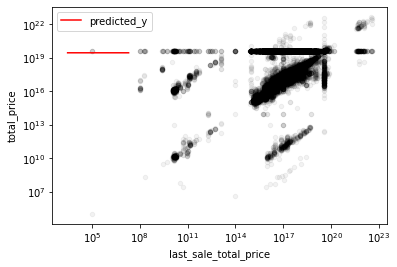

In [92]:
ax = predict_df.plot.line(x="last_sale_total_price", y="predicted_y", color="red")
pricenft.plot.scatter(x="last_sale_total_price", y="total_price", ax=ax, color="black", alpha=0.05)
ax.set_yscale('log')
ax.set_xscale('log')

In [ ]:
# How can we get a formula for the relationship?

In [104]:
f"total_price ~= {round(model.coef_[0], 6)} * last_sale_total_price + {round(model.intercept_, 2)}"

'total_price ~= 0.298502 * last_sale_total_price + 2.7881676795722023e+19'

In [ ]:
# How well does our model fit the data?
# r^2 score (explained variance)

In [111]:
model.score(pricenft[["last_sale_total_price"]], pricenft["total_price"]) 

0.20041195320721206

In [113]:
train, test = train_test_split(pricenft)
len(train), len(test)

(65373, 21791)

In [120]:
model = LinearRegression()
model.fit(train[["last_sale_total_price"]], train["total_price"])
model.score(test[["last_sale_total_price"]], test["total_price"]) # r^2 score
#model.score(train[["last_sale_total_price"]], train["total_price"])

0.29061251567169877

In [115]:
# How can we minimize noise due to random train/test splits?
scores = cross_val_score(model, train[["last_sale_total_price"]], train["total_price"])
scores

array([ 0.00599564,  0.01790183, -0.04691402,  0.16134844, -0.02947376])

In [116]:
scores.mean()

0.021771626334149217

In [117]:
scores.std()

0.07360618502785922

In [118]:
all_nfts.columns

Index(['asset_token_id', 'collection_slug', 'created_date', 'id', 'quantity',
       'listing_time', 'event_type', 'total_price', 'auction_type', 'duration',
       'primary_asset_contracts_address', 'display_data_card_display_style',
       'safelist_request_status', 'telegram_url', 'twitter_username',
       'instagram_username', 'discord_url', 'medium_username', 'external_url',
       'token_id', 'owner_address', 'last_sale_total_price', 'name',
       'num_sales', 'asset_contract_owner', 'asset_favorites',
       'asset_category', 'num_check', 'favorite', 'date'],
      dtype='object')

In [130]:
# multivariable linear regression
# favorite, num_sales, duration,aution_type(english=0,dutch=1)
regnft = all_nfts.filter(['favorite','num_sales','total_price','duration','last_sale_total_price'], axis=1)


In [131]:
mean=regnft.mean()
mean["total_price"]
mean["last_sale_total_price"]
mean

favorite                 5.454577e+01
num_sales                4.540096e+01
total_price              3.837193e+19
duration                 1.330194e+07
last_sale_total_price    3.514300e+19
dtype: float64

In [132]:
regnft['total_price'] = regnft['total_price'].fillna(mean["total_price"])
regnft['last_sale_total_price'] = regnft['last_sale_total_price'].fillna(mean["last_sale_total_price"])
regnft['num_sales'] = regnft['num_sales'].fillna(mean["num_sales"])
regnft['favorite'] = regnft['favorite'].fillna(mean["favorite"])
regnft['duration'] = regnft['duration'].fillna(mean["duration"])

regnft

,favorite,num_sales,total_price,duration,last_sale_total_price
0,17.0,2.0,3.837193e+19,5.576750e+05,4.000000e+16
1,17.0,2.0,3.837193e+19,5.748060e+05,4.000000e+16
2,17.0,2.0,3.837193e+19,6.048880e+05,4.000000e+16
3,17.0,2.0,5.000000e+16,1.330194e+07,4.000000e+16
4,17.0,2.0,3.837193e+19,1.330194e+07,4.000000e+16
...,...,...,...,...,...
87160,0.0,0.0,3.837193e+19,1.330194e+07,3.514300e+19
87161,1.0,0.0,3.837193e+19,1.563849e+07,3.514300e+19
87162,1.0,0.0,3.837193e+19,1.330194e+07,3.514300e+19
87163,1.0,0.0,3.837193e+19,1.330194e+07,3.514300e+19


In [134]:
train, test = train_test_split(regnft)
len(train), len(test)

(65373, 21791)

In [135]:
xcols = ['favorite','num_sales','duration','last_sale_total_price']

model = LinearRegression()
model.fit(train[xcols], train["total_price"]) # training

model.score(test[xcols], test["total_price"])

0.1475182199472933

In [139]:
from sklearn.ensemble import RandomForestRegressor
forest1 = RandomForestRegressor(n_estimators=100,
                                random_state=123,
                                max_depth = 50)
forest1.fit(train[xcols], train["total_price"])
forest1.score(test[xcols], test["total_price"])

0.1423468317874651

In [ ]:
from xgboost import XGBRegressor
xg_classifier1 = XGBRegressor(random_state = 123)
xg_classifier1.fit(train[xcols], train["total_price"])
print(xg_classifier1.score(train[xcols], train["total_price"]))
print(xg_classifier1.score(test[xcols], test["total_price"]))

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation
import numpy as np

## App Setup

In [23]:
# Setup the style from the link:
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']
# Embed the style to the dashabord:
app = dash.Dash(__name__, external_stylesheets=external_stylesheets)
#app = dash.Dash(__name__)

In [24]:
app.layout = html.Div([
    html.H2(children="NFT Analytical Dashboard"),
    

    html.Div([dcc.Graph(id='pie_chart', figure=pie_chart, className='four columns'),
              dcc.Graph(id='bar_chart', figure=bar_chart, className='four columns'),
              dcc.Graph(id='box_chart', figure=box_chart, className='three columns')
             ]),

    
    html.Div([dcc.Graph(id='line_chart_sales', figure=line_chart_sales, className='four columns'), 
              dcc.Graph(id='scatter_plot', figure=scatter_plot, className='four columns'),
              dcc.Graph(id='line_chart_auction', figure=line_chart_auction, className='three columns')
             ]),
    
    # Set up some end notes
    html.H2(children= 'Produced by RMDS Lab for 2022 Q1 Competition'),
    
    dcc.Link(children= 'See Competition Page    &   ', href = 'https://grmds.org/comp/nft', target = 'https://grmds.org/comp/nft'),
    
    dcc.Link(children= 'RMDS Covid Risk Map', href = 'https://grmds.org/risk/', target = 'https://grmds.org/risk/')

], style={"text-align": "center"})



NameError: name 'box_chart' is not defined

In [25]:
if __name__ == "__main__":
    app.run_server(port=7998)

Dash is running on http://127.0.0.1:7998/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:7998/ (Press CTRL+C to quit)
